In [1]:
import sys
import math
import re
import matplotlib.pyplot as plt
import sys
import numpy

start_time = 2000000000
pktsize = 1500
link_bandwidth = 100
propagation_delay_in_ns = 500
NUM_HOSTS_PER_AGG = 16
payload_size = 1000
header_size = 48
flow_size = header_size + payload_size
host_start_id = 14
num_hosts_per_tor_switch = 2

def extract_numer(exp):
    res = re.findall(r"\d", exp)
    res = "".join([str(e) for e in res])
    return res

def ipToNode(ip):
    return (int(ip, 16)-int('0b000001', 16))/int('00000100', 16)

def idealTime(link_bandwidth, NUM_HOSTS_PER_AGG, flowsize, src, dst): # res in ns
    # if(src/NUM_HOSTS_PER_AGG == dst/NUM_HOSTS_PER_AGG):
    if (src-host_start_id) // num_hosts_per_tor_switch == (dst-host_start_id) // num_hosts_per_tor_switch:
        num_hops = 2
    else:
        num_hops = 4
        
    num_packets = math.ceil(float(flowsize) / float(payload_size))
    assert(num_packets >= 1)
    packet_size = payload_size + header_size
    packet_transmission_delay = int(float(packet_size)*8/link_bandwidth)
    header_transmission_delay = int(float(header_size)*8/link_bandwidth) # ack packet only has header
    res = (propagation_delay_in_ns + packet_transmission_delay) * num_hops + (num_packets-1) * packet_transmission_delay + (propagation_delay_in_ns + header_transmission_delay) * num_hops
    res = round(res)
    # print(f"fct: {res} propagation_delay_in_ns: {propagation_delay_in_ns} packet_transmission_delay: {packet_transmission_delay} header_transmission_delay: {header_transmission_delay} num_packets: {num_packets}")
    return res

interval_list = ["20us", "50us", "100us", "500us", "1ms"]
protocol = "dcqcn"
sending_rate = {} # {node_id: {qp: {port: {time: rate}}}}
pfc = {} # {node_id: {port: {ts: pause/resume}}}
accumulated_pause_time = {} # {node: {port: pause_time}}
duration = {}
paused_time_ratio = {} # {node: {port: ratio}}
num_pauses = {}
sender_ecn = {} # {sender_id: {qp_key: [time]}}
sender_num_ecn = {} # {sender_id: {qp_key: num}}
num_mark_ecn = {} # {node_id: {port: num_mark}}
mark_ecn_timeline = {} # {node_id: {port: {ts: (ingress, shared_use)}}}
# send_pfc_timeline = {} # {node_id: {port: {ts: (type, ingress, shared_use)}}}
ingress_q_size = {} # {node_id: {port: ts: {bytes, thres}}}
egress_q_size = {} # {node_id: {port: ts: {bytes, thres}}}

xput_ratio = {} 
culprit_xput_sum = {}
victim_xput_sum = {}

culprit_senders = [14, 16, 19]
victim_senders = [15, 17, 18]

for interval in interval_list:
    print(f"interval: {interval}")
    output_dir = f"./exp/fattree/interval/{protocol}/{interval}"
    sending_rate_file = f"{output_dir}/sending-rate.txt"
    pfc_file = f"{output_dir}/pfc.txt"
    sender_ecn_file = f"{output_dir}/sender_ecn.txt"
    switch_mark_ecn_file = f"{output_dir}/switch_mark_ecn.txt"
    fct_file = f"{output_dir}/fct.txt"
    # send_pfc_file = f"{output_dir}/send_pfc.txt"
    q_size_file = f"{output_dir}/q_size.txt"
    
    """ sender throughput && duration """
    print("\tsender throughput && duration")
    xput_dict = {}
    duration[interval] = 0
    with open(fct_file) as ff:
        for line in ff:
            line_str = line.split()
            # src = ipToNode(line_str[0])
            # dst = ipToNode(line_str[1])
            src = int(line_str[0])
            dst = int(line_str[1])
            flowsize = int(line_str[4])
            fct = int(line_str[6])
            ideal_fct = idealTime(link_bandwidth, NUM_HOSTS_PER_AGG, flowsize, src, dst)
            duration[interval] = max(duration[interval], fct)
            
            _xput = float(flowsize*8.0) / float(fct)  
            ideal_xput = float(flowsize*8.0) / float(ideal_fct)
            
            ratio = float(ideal_fct)/float(fct)
            # new_line = f"src: {src}, dst: {dst} start: {float(line_str[5])/1e9}, flow_size: {flow_size}, fct: {fct} ({ideal_fct}), xput: {round(_xput, 2)} ({round(ideal_xput,2)}), ratio: {round(ratio, 2)}"
            # print(new_line)
            
            if src not in xput_dict:
                xput_dict[src] = {}
            if dst not in xput_dict[src]:
                xput_dict[src][dst] = []
            xput_dict[src][dst].append([_xput, ideal_xput, ratio])
    xput_ratio[interval] = {}
    for src in xput_dict:
        xput_ratio[interval][src] = {}
        # print(f"src: {src}")
        for dst in xput_dict[src]:
        #     pair_xput = [f[0] for f in xput_flow[src][dst]]
        #     pair_ideal_xput = [f[1] for f in xput_flow[src][dst]]
            pair_ratio = [f[2] for f in xput_dict[src][dst]]
            # pair_ratio = round(sum(pair_ratio)*100)
            xput_ratio[interval][src][dst] = round(sum(pair_ratio)*100)
            
    culprit_xput_sum[interval] = sum([sum(xput_ratio[interval][c].values()) for c in culprit_senders])
    victim_xput_sum[interval] = sum([sum(xput_ratio[interval][v].values()) for v in victim_senders])


    """ 
    ###################### sending rate ######################
    """
    print("\tsending rate")
    sending_rate[interval] = {}
    qpkey_to_id = {}
    with open(sending_rate_file) as srf:
        for i, line in enumerate(srf):
            line_str = line.split()
            # print(line_str)
            ts = int(line_str[0]) - start_time
            node_id = int(line_str[1])
            qp_key = int(line_str[2])
            port = int(line_str[3])
            rate = float(line_str[4]) / float(1000000000);
            
            if node_id not in qpkey_to_id:
                qpkey_to_id[node_id] = {}
            if qp_key not in qpkey_to_id[node_id]:
                idx = len(qpkey_to_id[node_id])
                qpkey_to_id[node_id][qp_key] = idx
            qp_key = qpkey_to_id[node_id][qp_key]
            
            if node_id not in sending_rate[interval]:
                sending_rate[interval][node_id] = {}
            if qp_key not in sending_rate[interval][node_id]:
                sending_rate[interval][node_id][qp_key] = {}
            if port not in sending_rate[interval][node_id][qp_key]:
                sending_rate[interval][node_id][qp_key][port] = {}
            sending_rate[interval][node_id][qp_key][port][ts] = rate        
            
    """  
    ###################### PFC ######################
    """
    print("\tpfc")
    pfc[interval] = {}
    with open(pfc_file) as pfcf:
        for i, line in enumerate(pfcf):
            line_str = line.split()
            ts = int(extract_numer(line_str[1])) - start_time
            node_id = int(extract_numer(line_str[3]))
            port = int(extract_numer(line_str[7]))
            pfc_type = int(extract_numer(line_str[9]))
            # print(ts, node_id, port, pfc_type)
            if node_id not in pfc[interval]:
                pfc[interval][node_id] = {}
            if port not in pfc[interval][node_id]:
                pfc[interval][node_id][port] = {}
            pfc[interval][node_id][port][ts] = pfc_type
            
    """  
    ###################### send PFC ######################
    """
    # send_pfc_timeline[interval] = {}
    # with open(send_pfc_file) as send_pfc_f:
    #     for i, line in enumerate(send_pfc_f):
    #         line_str = line.split()
    #         ts = int(extract_numer(line_str[1])) - start_time
    #         node_id = int(extract_numer(line_str[3]))
    #         port = int(extract_numer(line_str[5]))
    #         pfc_type = int(extract_numer(line_str[7]))
    #         ingress_bytes = int(extract_numer(line_str[9]))
    #         shared_use = int(extract_numer(line_str[11]))
    #         pfc_thres = int(extract_numer(line_str[13]))
    #         # print(ts, node_id, port, pfc_type)
    #         if node_id not in send_pfc_timeline[interval]:
    #             send_pfc_timeline[interval][node_id] = {}
    #         if port not in send_pfc_timeline[interval][node_id]:
    #             send_pfc_timeline[interval][node_id][port] = {}
    #         send_pfc_timeline[interval][node_id][port][ts] = (pfc_type, ingress_bytes, shared_use, pfc_thres)
            
    """  
    ###################### num pauses ######################
    """
    print("\tnum_pauses")
    num_pauses[interval] = {}
    for node_id in pfc[interval]:
        num_pauses[interval][node_id] = {}
        for port in pfc[interval][node_id]:
            num_pauses[interval][node_id][port] = len(pfc[interval][node_id][port]) // 2
    
    """ 
    ###################### accumulated pause time && ratio ######################
    """
    print("\taccumulated pause time && ratio")
    accumulated_pause_time[interval] = {}     
    paused_time_ratio[interval] = {}     
    for node_id in pfc[interval]:
        accumulated_pause_time[interval][node_id] = {}
        paused_time_ratio[interval][node_id] = {}
        for port in pfc[interval][node_id]:
            # accumulated_pause_time[interval][node_id][port] = {}
            accum = 0
            last_pause = 0
            for tx, pause_resume in pfc[interval][node_id][port].items():
                if node_id >=host_start_id and tx > list(sending_rate[interval][node_id][0][port].keys())[-1]:
                    break
                if pause_resume == 1:
                    # accumulated_pause_time[interval][node_id][port][tx] = accum
                    last_pause = tx
                else:
                    accum += (tx - last_pause)
                    # accumulated_pause_time[interval][node_id][port][tx] = accum
            accumulated_pause_time[interval][node_id][port] = accum
            paused_time_ratio[interval][node_id][port] = accum/duration[interval]

    """ 
    ###################### get sender receives ecn ######################
    """
    print("\tsender_ecn")
    sender_ecn[interval] = {}
    with open(sender_ecn_file) as sef:
        for i, line in enumerate(sef):
            line_str = line.split()
            # print(line_str)
            # break
        
            ts = int(line_str[0]) - start_time
            node_id = int(line_str[1])
            # sender_id = int(line_str[2])
            qp_key = int(line_str[2])
            qp_key = qpkey_to_id[node_id][qp_key]
            port = int(line_str[3])
            assert(port==1)
            
            if node_id not in sender_ecn[interval]:
                sender_ecn[interval][node_id] = {}
            if qp_key not in sender_ecn[interval][node_id]:
                sender_ecn[interval][node_id][qp_key] = []
            sender_ecn[interval][node_id][qp_key].append(ts)   
            
    """ 
    ###################### number of ecns that sender receives ######################
    """
    print("\tnumber of ecns that sender receives")
    sender_num_ecn[interval] = {}
    for node_id in sender_ecn[interval]:
        sender_num_ecn[interval][node_id] = {}
        for qp_key in sender_ecn[interval][node_id]:
            sender_num_ecn[interval][node_id][qp_key] = len(sender_ecn[interval][node_id][qp_key])
            
            
    """
    ###################### switch mark ecn ######################
    """
    print("\tswitch mark ecn")
    num_mark_ecn[interval] = {}
    mark_ecn_timeline[interval] = {}
    with open(switch_mark_ecn_file) as smf:
        for i, line in enumerate(smf):
            line_str = line.split()
            ts = int(line_str[0]) - start_time
            node_id = int(line_str[1])
            sender_id = int(line_str[2])
            port = int(line_str[3])
            egress_bytes = int(line_str[4])
            
            if node_id not in num_mark_ecn[interval]:
                num_mark_ecn[interval][node_id] = {}
                mark_ecn_timeline[interval][node_id] = {}
            if port not in num_mark_ecn[interval][node_id]:
                num_mark_ecn[interval][node_id][port] = 0
                mark_ecn_timeline[interval][node_id][port] = {}
            num_mark_ecn[interval][node_id][port] +=1
            mark_ecn_timeline[interval][node_id][port][ts] = egress_bytes
            
    # """
    # ###################### q size ######################
    # """
    # print("\tq size")
    # ingress_q_size[interval] = {}
    # egress_q_size[interval] = {}
    # with open(q_size_file) as q_size_f:
    #     for i, line in enumerate(q_size_f):
    #         line_str = line.split()
    #         ts = int(line_str[0]) - start_time
    #         node_id = int(line_str[1])
    #         port = int(line_str[2])
    #         q_type = int(line_str[3])
    #         bytes = int(line_str[4])
    #         thres = int(line_str[5])
            
    #         if q_type == 1: # ingress
    #             if node_id not in ingress_q_size[interval]:
    #                 ingress_q_size[interval][node_id] = {}
    #             if port not in ingress_q_size[interval][node_id]:
    #                 ingress_q_size[interval][node_id][port] = {}
    #             ingress_q_size[interval][node_id][port][ts] = bytes
    #         else: # egress
    #             if node_id not in egress_q_size[interval]:
    #                 egress_q_size[interval][node_id] = {}
    #             if port not in egress_q_size[interval][node_id]:
    #                 egress_q_size[interval][node_id][port] = {}
    #             egress_q_size[interval][node_id][port][ts] = bytes 

interval: 20us
	sender throughput && duration
	sending rate
	pfc
	num_pauses
	accumulated pause time && ratio
	sender_ecn
	number of ecns that sender receives
	switch mark ecn
interval: 50us
	sender throughput && duration
	sending rate
	pfc
	num_pauses
	accumulated pause time && ratio
	sender_ecn
	number of ecns that sender receives
	switch mark ecn
interval: 100us
	sender throughput && duration
	sending rate
	pfc
	num_pauses
	accumulated pause time && ratio
	sender_ecn
	number of ecns that sender receives
	switch mark ecn
interval: 500us
	sender throughput && duration
	sending rate
	pfc
	num_pauses
	accumulated pause time && ratio
	sender_ecn
	number of ecns that sender receives
	switch mark ecn
interval: 1ms
	sender throughput && duration
	sending rate
	pfc
	num_pauses
	accumulated pause time && ratio
	sender_ecn
	number of ecns that sender receives
	switch mark ecn


In [ ]:
# per sender sending rate, pfc, ecn
for node_to_plot in [14, 15]:
    fig, ax = plt.subplots(1, 3, figsize=(20,10))
    for idx, node_id in enumerate(sending_rate.keys()):
        if node_id != node_to_plot:
            continue
        for qp_key in sending_rate[node_id]:
            assert(len(sending_rate[node_id][qp_key])) == 1
            port = 1
            
            # sending rate
            x = list(sending_rate[node_id][qp_key][port].keys())
            y = list(sending_rate[node_id][qp_key][port].values())
            ax[0].scatter(x, y, label = f"node-{node_id}-flow-{qp_key}-port-{port}", s=0.1)
            ax[0].set_title(f'Sending rate')
            ax[0].set_xlabel("Timestamp (ns)")
            ax[0].set_ylabel("Sending Rate (Gbps)")
            x_max = max(x)
            ax[0].set_xlim([0, x_max])
            ax[0].grid()
            ax[0].legend(loc="upper right")
            
            # receive pfc
            for tx, pause_resume in pfc[node_id][port].items():
                ax[0].axvline(x=tx, color='red' if pause_resume == 1 else 'green', ls=':', lw=1)        
            
            # ecn
            x = sender_ecn[node_id][qp_key]
            y = [i+1 for i in range(len(x))]
            ax[1].plot(x, y, label = f"node-{node_id}-flow-{qp_key}-port-{port}")
            ax[1].set_xlim([0, x_max])
            ax[1].grid()
            ax[1].set_title(f'Num. ECN')
            ax[1].set_xlabel("Timestamp (ns)")
            ax[1].set_ylabel("Accum. num. ECNs received")
            
            # pfc
            x = list(accumulated_pause_time[node_id][port].keys())
            y = list(accumulated_pause_time[node_id][port].values())
            ax[2].plot(x, y, label=f"port-{port}")
            ax[2].set_xlim([0, x_max])
            ax[2].set_title(f'Accum. pause time')
            ax[2].set_xlabel("Timestamp (ns)")
            ax[2].set_ylabel("Accum. Paused time (ns)")
            ax[2].grid()
            ax[2].legend()

    import matplotlib.pylab as pylab
    params = {'legend.fontsize': 'x-large',
            #   'figure.figsize': (15, 10),
            'axes.labelsize': 'x-large',
            'axes.titlesize':'x-large',
            'xtick.labelsize':'x-large',
            'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    # plt.grid()
    plt.tight_layout()
    # plt.legend() 
    # plt.show()
    plt.savefig(f"{output_dir}/node-{node_to_plot}.png")

In [ ]:
# accumulated pause time

# check PFC at each node, not just senders
accumulated_pause_time = {}

for node_id in pfc:
    if node_id not in [0,1,2,5,6,7,14,15]:
        continue
    accumulated_pause_time[node_id] = {}
    for port in pfc[node_id]:
        accumulated_pause_time[node_id][port] = {}
        accum = 0
        last_pause = 0
        for tx, pause_resume in pfc[node_id][port].items():
            if pause_resume == 1:
                accumulated_pause_time[node_id][port][tx] = accum
                last_pause = tx
            else:
                accum += (tx - last_pause)
                accumulated_pause_time[node_id][port][tx] = accum

fig, ax = plt.subplots(len(accumulated_pause_time), 2, figsize=(30, 60))

for idx, node_id in enumerate(accumulated_pause_time.keys()):
    
    for port in accumulated_pause_time[node_id]:
        x = list(accumulated_pause_time[node_id][port].keys())
        y = list(accumulated_pause_time[node_id][port].values())
        ax[idx,0].plot(x, y, label=f"port-{port}")
        ax[idx,0].set_title(f'Node-{node_id}')
        ax[idx,0].set_xlabel("Timestamp (ns)")
        ax[idx,0].set_ylabel("Accum. Paused time (ns)")
        ax[idx,0].grid()
        ax[idx,0].legend()
        # ax[idx,0].setsize
        
        for tx, pause_resume in pfc[node_id][port].items():
            ax[idx,1].axvline(x=tx, ymin=0.2*port, ymax=0.2*port+0.1, color='red' if pause_resume == 1 else 'green', ls=':', lw=1)
        ax[idx,1].set_xlabel("Timestamp (ns)")
        # ax[idx,1].set_ylabel("Accum. Paused time (ns)")
        ax[idx,1].grid()
        # ax[idx,0].legend()
        
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
        #   'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# plt.grid()
plt.tight_layout()
# plt.legend() 
# plt.show()
plt.savefig(f"{output_dir}/pfc.png")

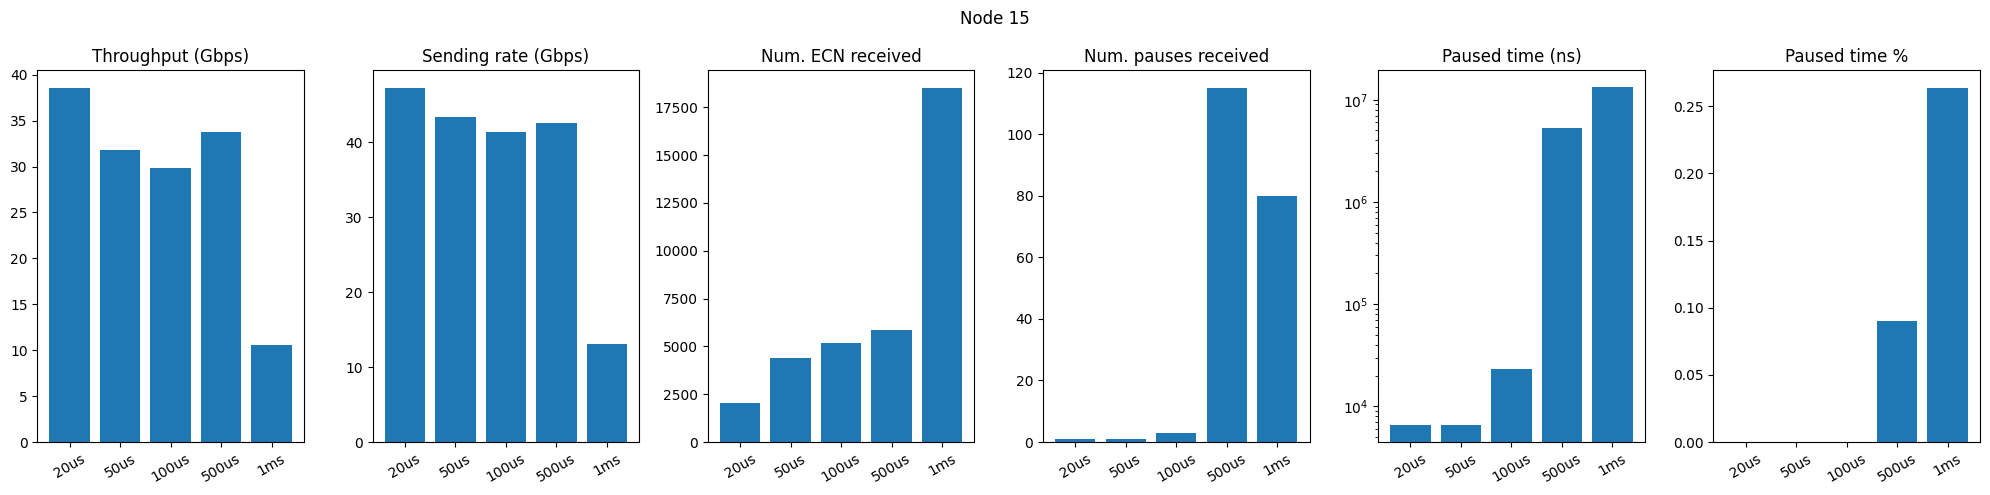

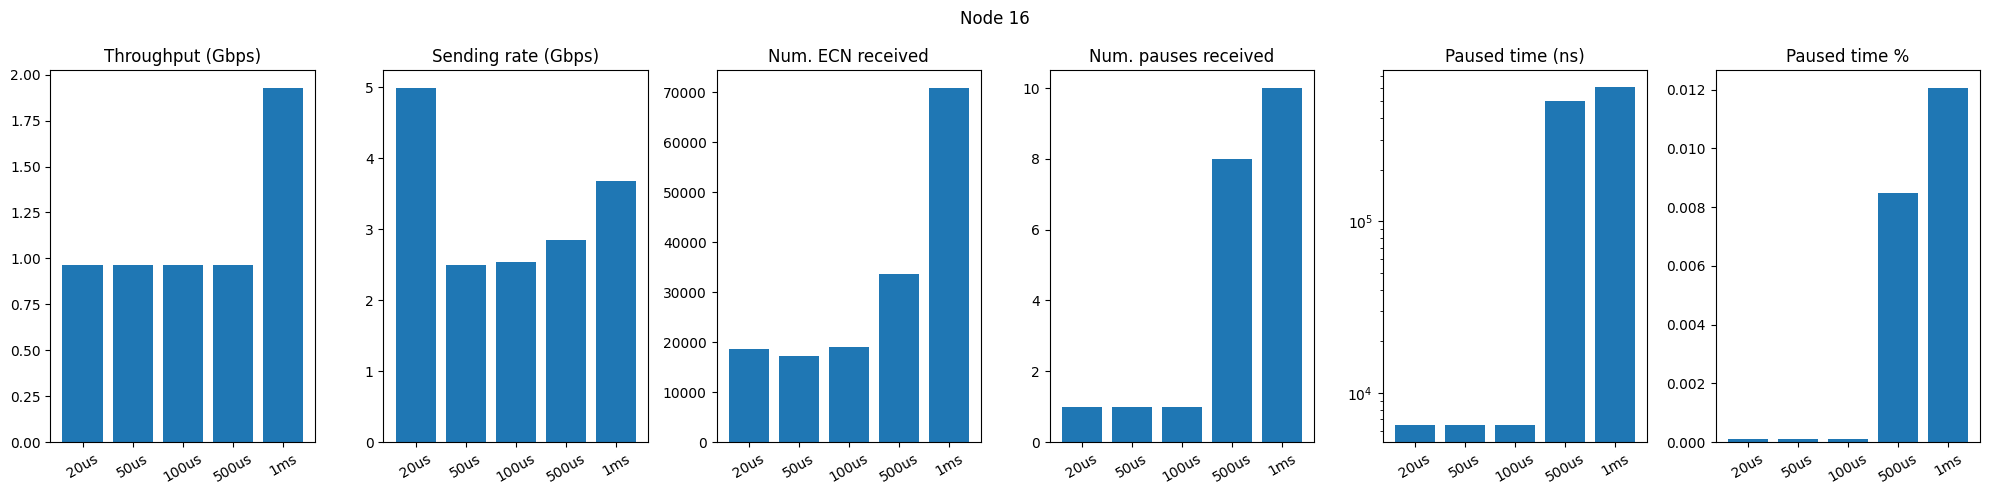

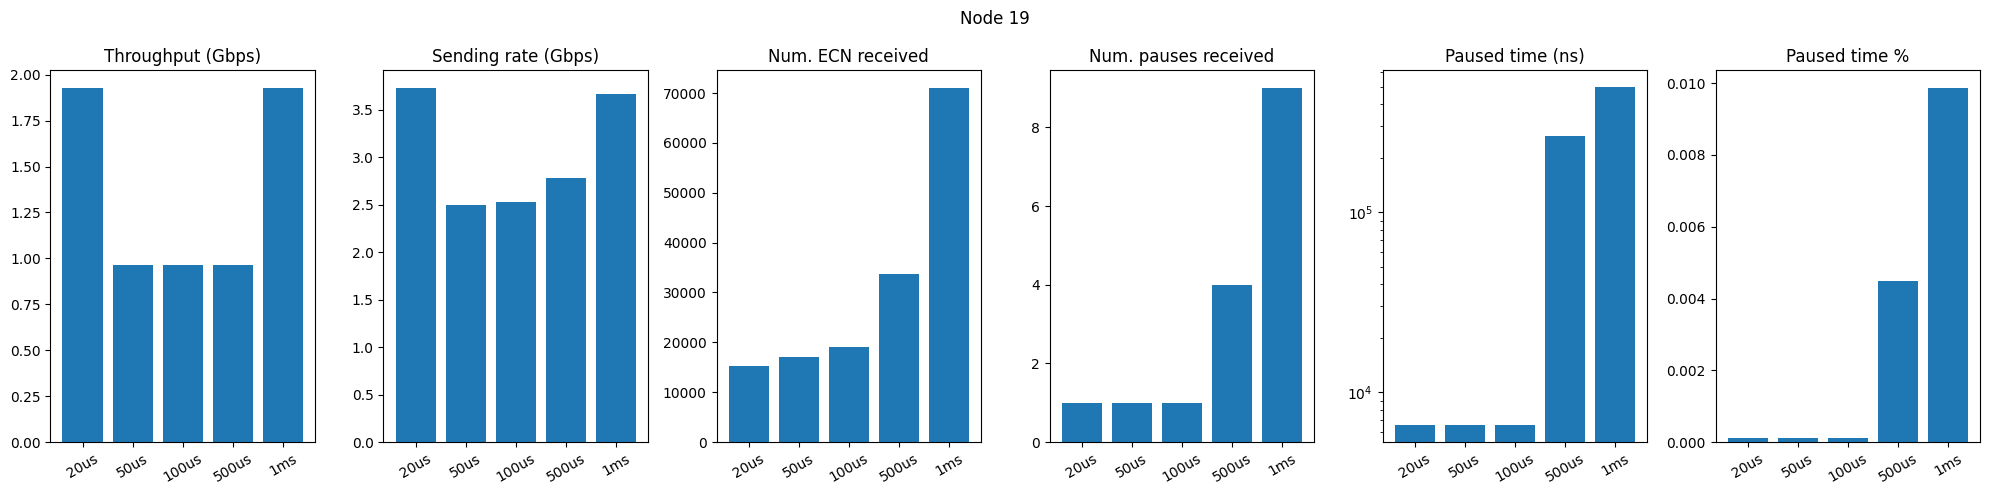

In [13]:
# sender
# print(len(sending_rate["1ms"][15][0][1]))
# print(len(sending_rate["20us"][15][0][1]))
# print(len(sender_ecn["1ms"][15][0]))
# print(len(sender_ecn["20us"][15][0]))
import numpy as np
senders_to_plot = [15, 16]
for node_id in senders_to_plot:
    fig, ax = plt.subplots(1, 6, figsize=(20, 5))
    x = list(range(len(interval_list)))
    xticks = interval_list
    
    qp_key = 0
    port = 1
    
    # y_xput = [sum(xput_ratio[interval][node_id].values()) for interval in interval_list]
    # y_sending_rate = [np.mean([rate for ts, rate in sending_rate[interval][node_id][qp_key][port].items() if ts<=_duration[interval]]) for interval in interval_list]
    # y_sender_ecn = [len([ts for ts in sender_ecn[interval][node_id][qp_key] if ts<=_duration[interval]]) for interval in interval_list]
    # y_num_pauses = [len([ts for ts in pfc[interval][node_id][port] if ts<=_duration[interval]]) // 2 for interval in interval_list]
    # y_paused_time = [[t for ts, t in accumulated_pause_time[interval][node_id][port].items() if ts<=_duration[interval]][-1] for interval in interval_list]
    
    y_xput = [sum(xput_ratio[interval][node_id].values()) for interval in interval_list]
    y_xput = [e / 100 * 96.38 for e in y_xput]
    y_sending_rate = [np.mean(list(sending_rate[interval][node_id][qp_key][port].values())) for interval in interval_list]
    y_sender_num_ecn = [sender_num_ecn[interval][node_id][qp_key] for interval in interval_list]
    y_num_pauses = [num_pauses[interval][node_id][port] for interval in interval_list]
    y_paused_time = [accumulated_pause_time[interval][node_id][port] for interval in interval_list]    
    y_paused_ratio = [paused_time_ratio[interval][node_id][port]*100 for interval in interval_list]
    
    
    ax[0].bar(x, y_xput)
    ax[0].set_xticks(x, xticks, rotation=30)
    ax[0].set_title("Throughput (Gbps)")
    
    ax[1].bar(x, y_sending_rate)
    ax[1].set_xticks(x, xticks, rotation=30)
    ax[1].set_title("Sending rate (Gbps)")
    
    ax[2].bar(x, y_sender_num_ecn)
    ax[2].set_xticks(x, xticks, rotation=30)
    ax[2].set_title("Num. ECN received")
    
    ax[3].bar(x, y_num_pauses)
    ax[3].set_xticks(x, xticks, rotation=30)
    ax[3].set_title("Num. pauses received")
    
    ax[4].bar(x, y_paused_time)
    ax[4].set_xticks(x, xticks, rotation=30)
    ax[4].set_yscale("log")
    ax[4].set_title("Paused time (ns)")
    
    ax[5].bar(x, y_paused_ratio)
    ax[5].set_xticks(x, xticks, rotation=30)
    ax[5].set_title("Paused time %")
    
    fig.suptitle(f'Node {node_id}')
    plt.tight_layout()
    plt.show()
        

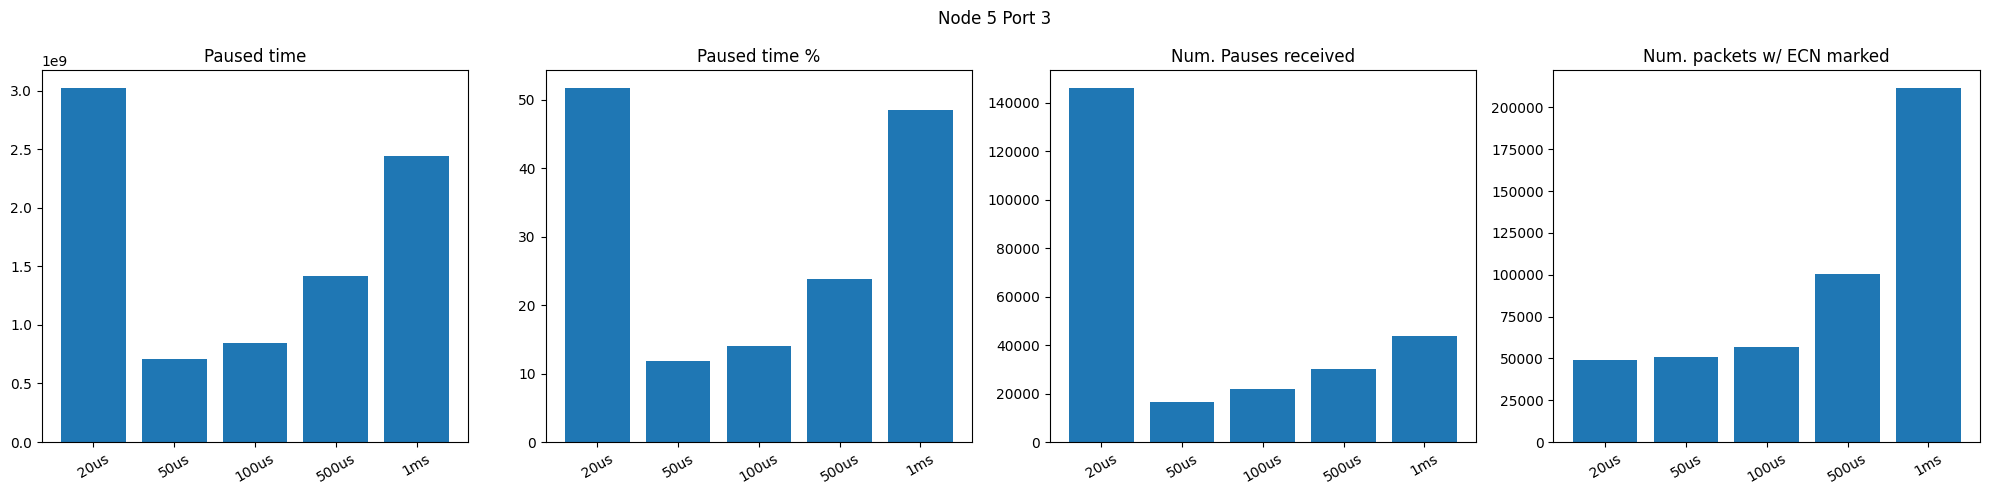

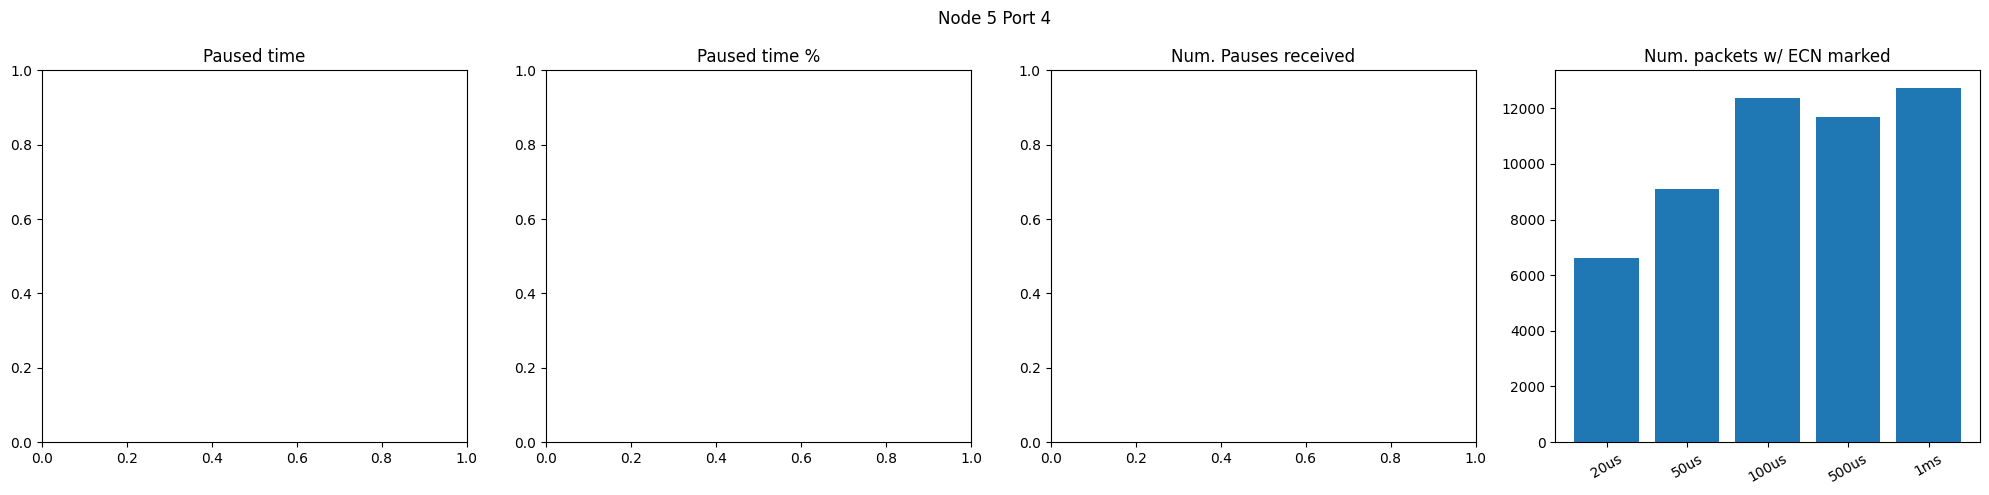

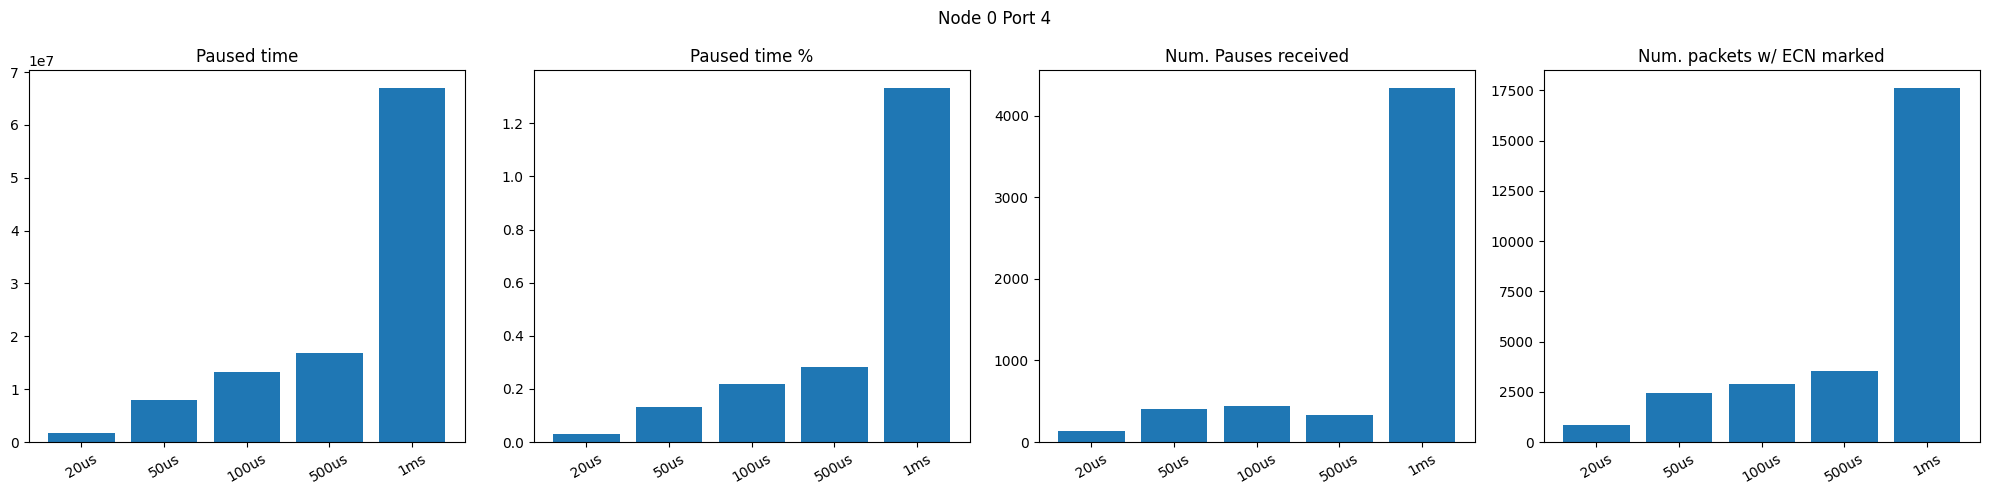

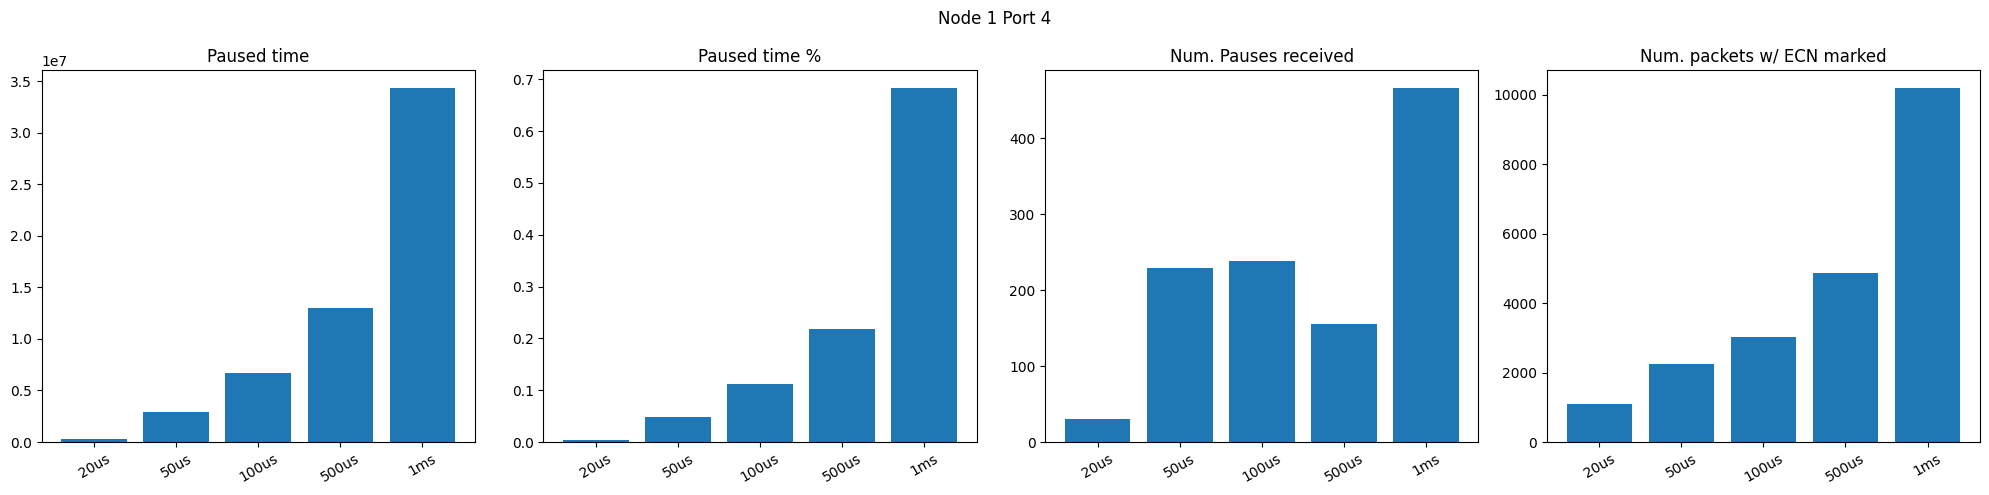

In [12]:
# analyze each nic and switch
# node_port = {5: [3], 0: [4], 1: [4], 2: [1,2], 6: [1], 7: [1], 14: [1], 15: [1]}
node_port = {5: [3], 0: [4], 1: [4], 2: [1,2], 6: [1], 7: [1]}
node_port = {5: [(3, "egress"), (4, "egress")], 0: [(4, "egress")], 1: [(4, "egress")]}
node_to_plot = list(node_port.keys())

for node_id, ports in node_port.items():
    for port, q_type in ports:
        fig, ax = plt.subplots(1, 4, figsize=(20, 5))
        x = list(range(len(interval_list)))
        xticks = interval_list

        if node_id in accumulated_pause_time[interval] and port in accumulated_pause_time[interval][node_id]:
            y_paused_time = [accumulated_pause_time[interval][node_id][port] for interval in interval_list]
            ax[0].bar(x, y_paused_time)
            ax[0].set_xticks(x, xticks, rotation=30)
        ax[0].set_title("Paused time")
       
        if node_id in paused_time_ratio[interval] and port in paused_time_ratio[interval][node_id]:
            y_paused_ratio = [paused_time_ratio[interval][node_id][port]*100 for interval in interval_list]
            ax[1].bar(x, y_paused_ratio)
            ax[1].set_xticks(x, xticks, rotation=30)
        ax[1].set_title("Paused time %")
        
        if node_id in num_pauses[interval] and port in num_pauses[interval][node_id]:
            y_num_pauses = [num_pauses[interval][node_id][port] for interval in interval_list]
            ax[2].bar(x, y_num_pauses)
            ax[2].set_xticks(x, xticks, rotation=30)
        ax[2].set_title("Num. Pauses received")
        
        if node_id in num_mark_ecn[interval] and port in num_mark_ecn[interval][node_id]:
            y_num_mark_ecn = [num_mark_ecn[interval][node_id][port] for interval in interval_list]   
            ax[3].bar(x, y_num_mark_ecn)
            ax[3].set_xticks(x, xticks, rotation=30)
        ax[3].set_title("Num. packets w/ ECN marked")
        
        # q_size = egress_q_size if q_type == "egress" else ingress_q_size
        # if node_id in q_size[interval] and port in q_size[interval][node_id]:
        #     y_q_size = [np.mean(list(q_size[interval][node_id][port].values())) for interval in interval_list]
        #     ax[4].bar(x, y_q_size)
        #     ax[4].set_xticks(x, xticks, rotation=30)
        # ax[4].set_title(f"Avg. {q_type} q size (Bytes)")
        
        fig.suptitle(f'Node {node_id} Port {port}')
        plt.tight_layout()
        plt.show()
        # plt.savefig(f".exp/fattree/interval/node-{node_id}.png")



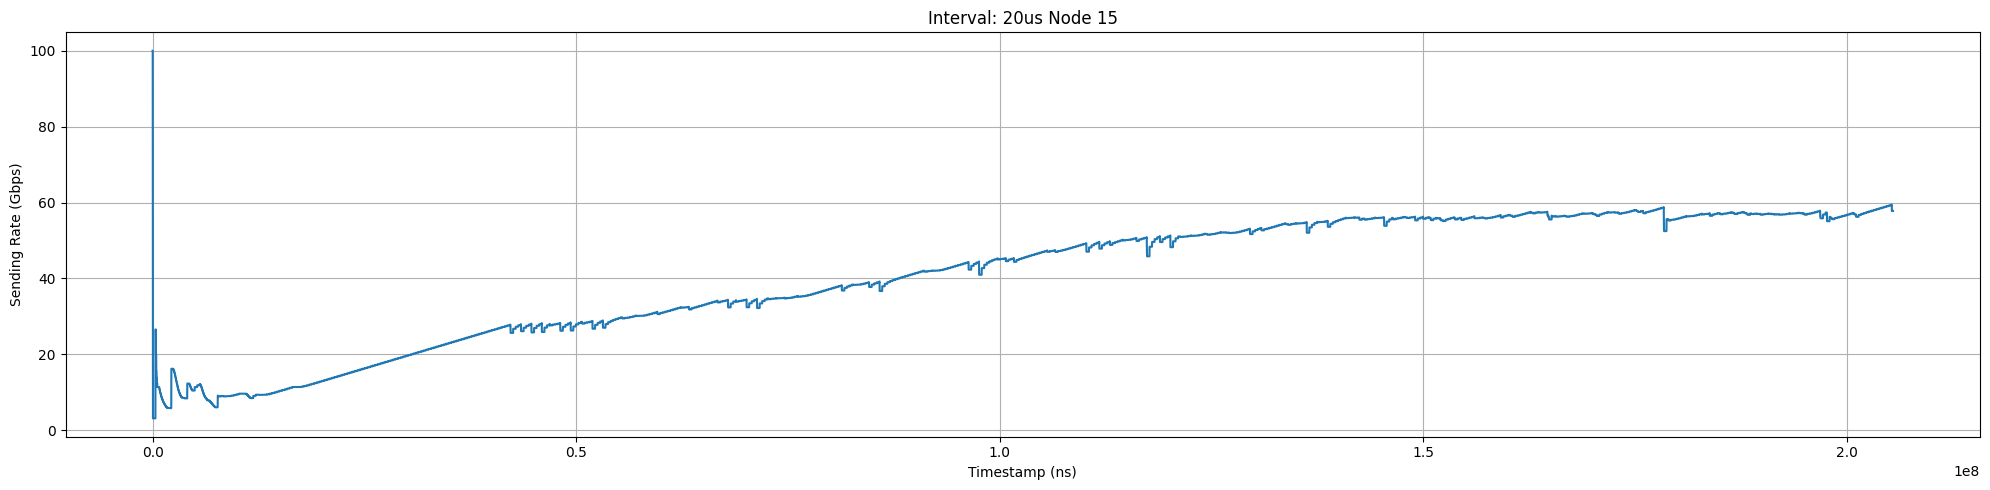

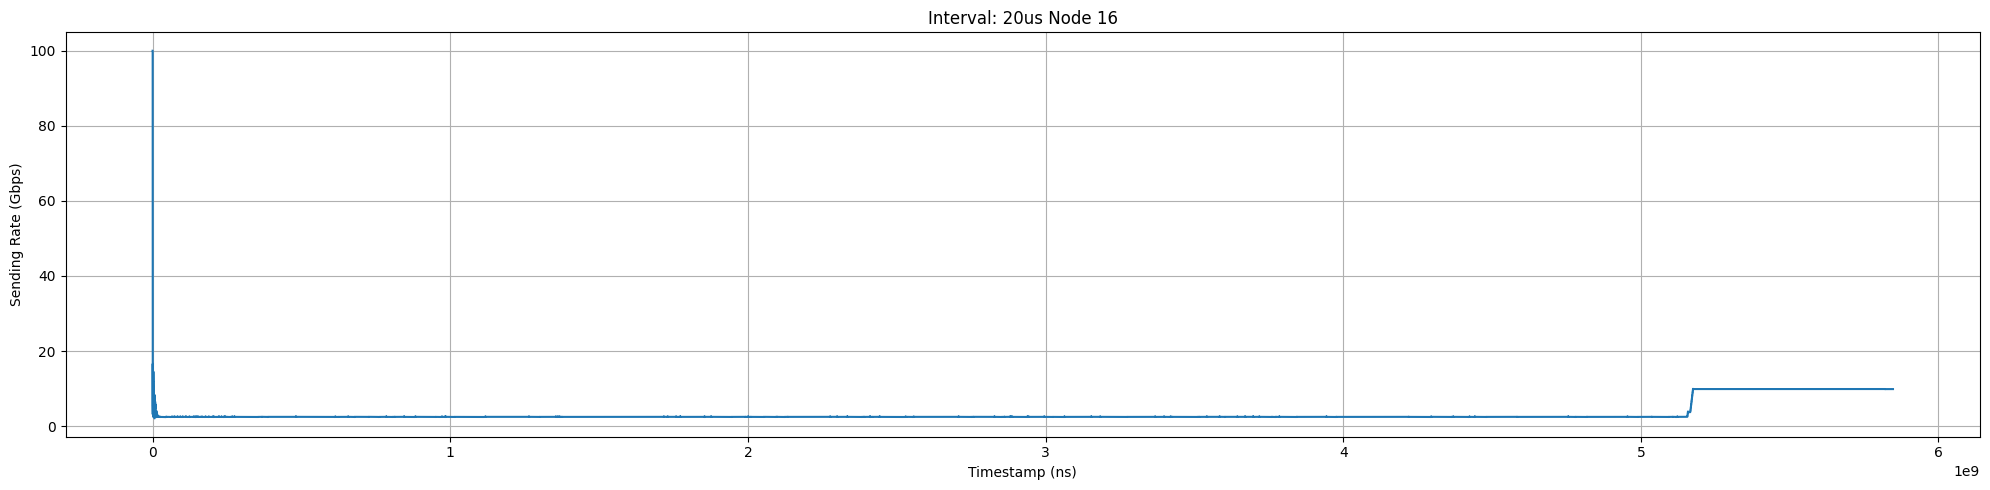

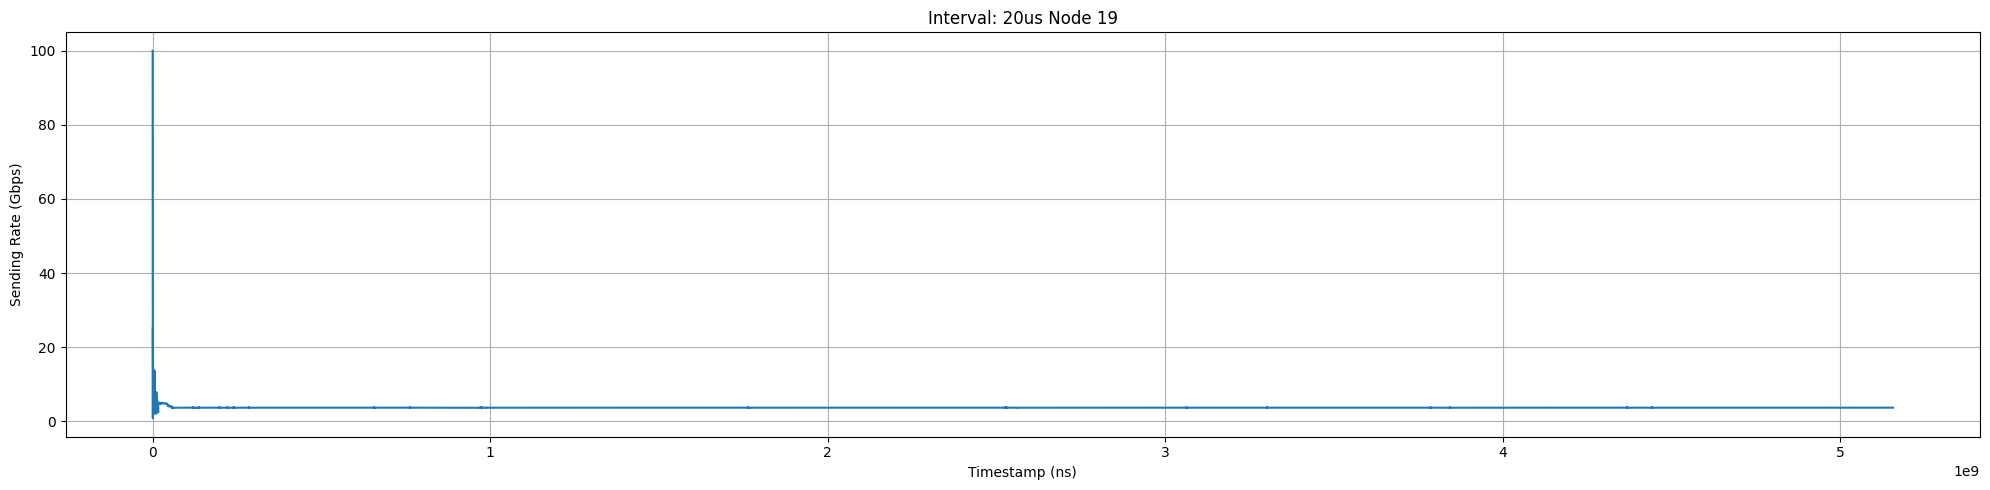

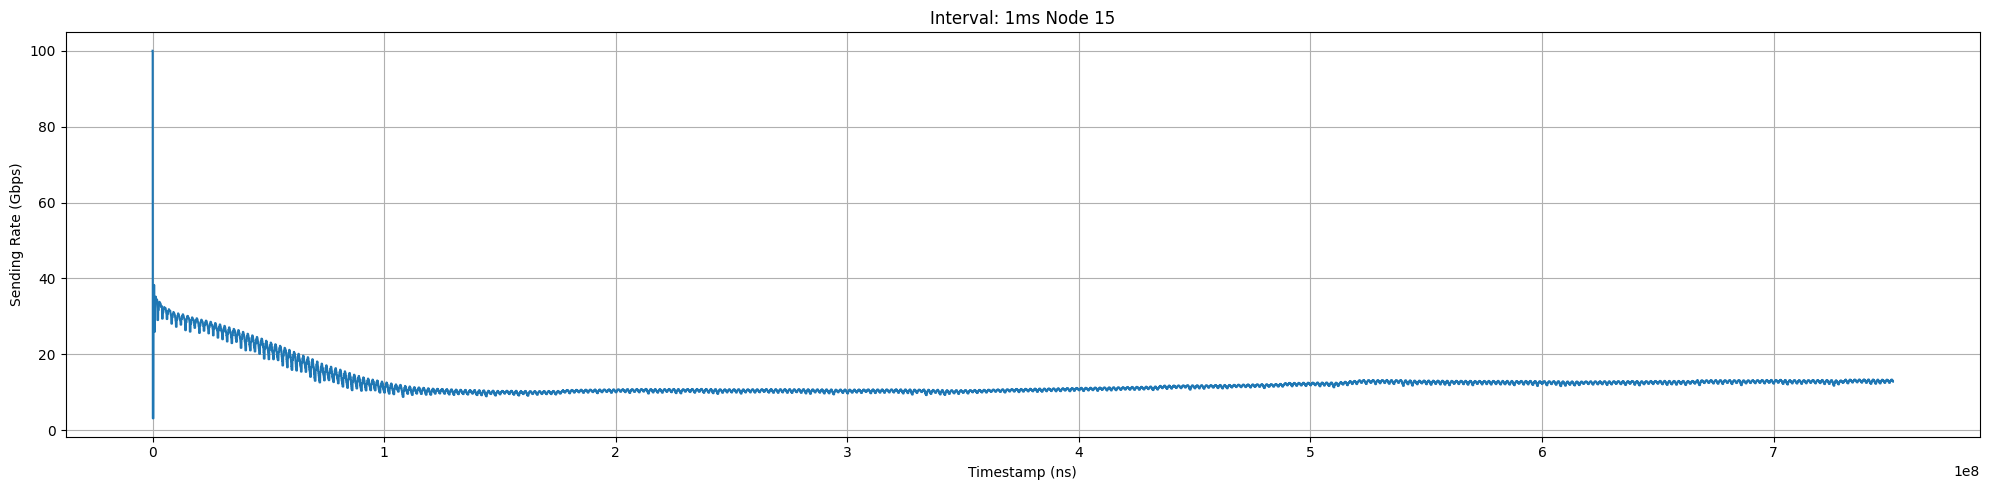

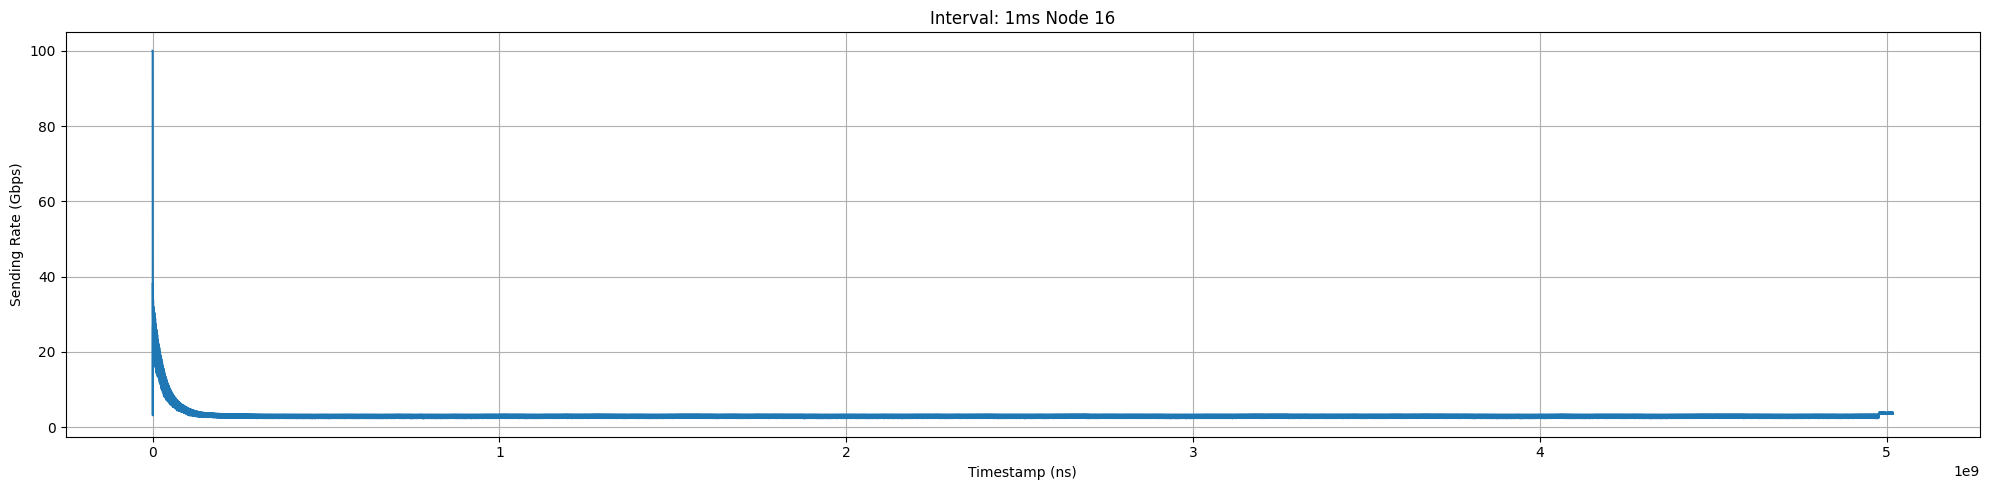

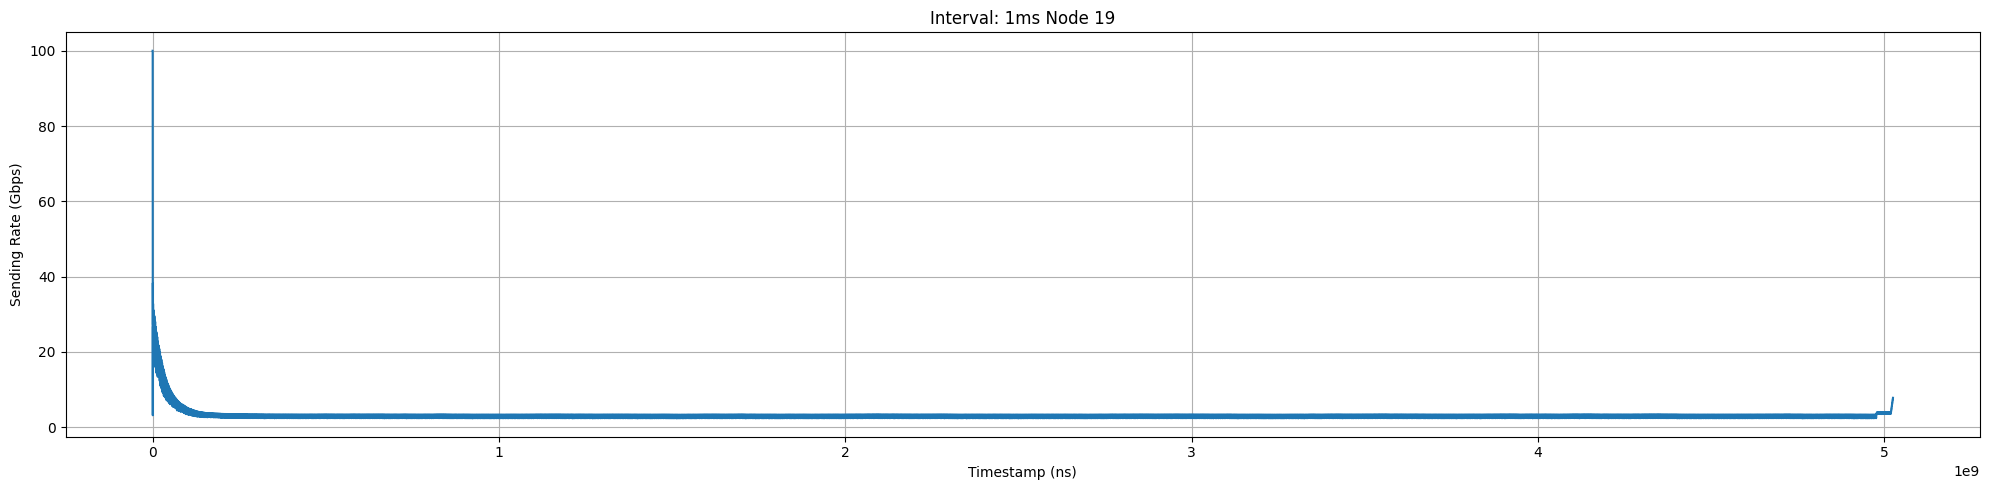

In [5]:
# timeline of sending rate
node_to_plot= [15, 16, 19]

for interval in ["20us", "1ms"]:
    for node_id in node_to_plot:
        qp_key = 0
        port = 1

        fig, ax = plt.subplots(1, 1, figsize=(20, 5))
        y = list(sending_rate[interval][node_id][qp_key][port].values())
        x = list(sending_rate[interval][node_id][qp_key][port].keys())
        ax.plot(x, y)
        ax.set_title(f"Interval: {interval} Node {node_id}")
        ax.set_xlabel("Timestamp (ns)")
        ax.set_ylabel("Sending Rate (Gbps)")
        # x_max = max(x)
        # ax[0].set_xlim([0, x_max])
        ax.grid()
        plt.tight_layout()
        plt.show()

    # x = list(range(len(y_q_size)))
    # xticks = list(q_size[interval][node_id][port].keys())[:100]
    # fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    #     y_sending_rate = list(sending_rate[interval][node_id][qp_key][port].values())
    #     ax.plot(x,)
    
    # q_size = egress_q_size if q_type == "egress" else ingress_q_size
    # y_q_size = list(q_size[interval][node_id][port].values())[:100]
    # x = list(range(len(y_q_size)))
    # xticks = list(q_size[interval][node_id][port].keys())[:100]
    # ax.scatter(x, y_q_size, s=0.1)
    # ax.set_xticks(x, xticks)
    # ax.set_title(f"xxx")
    
    # fig.suptitle(f'Node {node_id} Port {port} {q_type}')
    # plt.tight_layout()
    # plt.show()